**План проекта прогнозирования стоимости недвижимости**
* [1. Описание данных](#data_description)
    * [1.1 Загрузка данных и первый взгляд на них](#data_load)
    * [1.2 Гистограммы для числовых атрибутов](#data_hist)
    * [1.3 Создание отложенной выборки](#val_set)
* [2. Базовое решение](#base_des)
    * [2.1 Преобразование категориальных признаков](#dummies)
    * [2.2 Замена пропущенных значений](#mis_val_base)
    * [2.3 Построение базовой модели и её оценка](#base_mod)
* [3. Разведочный анализ данных (EDA)](#eda)
    * [3.1 Обработка выбросов](#outlier)
        * [3.1.1 HouseYear](#HouseYear)
        * [3.1.2 HouseFloor, Floor](#Floor)
        * [3.1.3 KitchenSquare](#KitchenSquare)
        * [3.1.4 Rooms](#Rooms)
        * [3.1.5 Square, LifeSquare](#Square)
    * [3.2 Создание класса DataPreprocessing](#DataPreprocessing)     
    * [3.3 Исследование признака 'DistrictId'](#DistrictId)
        * [3.3.1 Обзор 'DistrictId'](#DistrictId_re)
        * [3.3.2 Создание нового признака 'distr_cat'](#distr_cat)
        * [3.3.2 Обучение модели для прогнозирования признака 'distr_cat'](#distr_cat_pred)
    * [3.4 Матрица корреляций](#corr)
* [4. Построение новых признаков](#feature)
* [5. Построение модели](#modeling)

***Подключение библиотек и скриптов***

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [4]:
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [6]:
import matplotlib.style as style
style.use('fivethirtyeight')

matplotlib.rcParams.update({'font.size': 14})

***Пути к директориям и файлам***

In [7]:
DATASET_PATH = '../data/project_train.csv'
TEST_PATH = '../data/project_test.csv'
SUBM_PATH = '../data/sample_submission.csv'

***Вспомогательные функции***

1. 

In [8]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

2. График, позволяющий определить неинформативные признаки

In [9]:
def feature_info(df):
    # Малоинформативными считаем предикторы-выбросы либо по мощности (ось Х) 
    # либо по соотношению частот (ось Y)
    
    res = pd.DataFrame(df.columns, columns=['features'])
    
    # соотношение частот самого популярного значения относительно второго значения по частотности
    res['freqRation'] = 0
    
    # мощность или cardinality — доля уникального числа значений от общего числа значений
    res['percentUnique'] = 0
    
    for col in res.features:
        lst = list(df[col].value_counts().sort_values(ascending=False))
        res.loc[res.features == col, 'freqRation'] = lst[0] / lst[1]
        
        res.loc[res.features == col, 'percentUnique'] = 100 * len(df[col].unique()) / len(df)
        
    # Create as many colors as there are features
    categories = res['features']
    colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

    # Draw Plot for Each Category
    plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

    for i, category in enumerate(categories):
        plt.scatter('percentUnique', 'freqRation', data=res.loc[res.features==category, :], 
                s=20, c=np.array([colors[i]]), label=str(category))
       
        
    # Decorations
    plt.gca().set(xlabel='percentUnique', ylabel='freqRation', xscale='log', yscale='log')

    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    #plt.title("", fontsize=22)
    plt.legend(fontsize=12, ncol = 2)    
    plt.show()  

    return res

3. График зависимости оценки модели от числа признаков 

In [10]:
def feat_imp_draw(X, y, model=RandomForestRegressor(random_state=28, n_jobs=-1)):
    rf_model = model
    ab = range(len(X_train.columns), 0, -1)
    ordi = []
    cv_score_dt = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
    ordi.append(np.mean(cv_score_dt))

    rf_model.fit(X, y)
    feature_importances = pd.DataFrame(zip(X.columns, rf_model.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    df = feature_importances.sort_values(by='importance', ascending=False)

    for num in range(1, len(X_train.columns)):
        cv_score_dt = cross_val_score(rf_model, X[df[:-num].feature_name], y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
        ordi.append(np.mean(cv_score_dt))

    plt.plot(ab, ordi)
    plt.show()

    return df

## 1. Описание данных <a class='anchor' id='data_description'>

**Цель задачи** - предсказать стоимость недвижимости 

**Описание датасета**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

Метрика: коэффициент детерминации
$ R^2=1−\frac{σ^2}{σ^2_y}\ $

### 1.1 Загрузка данных и первый взгляд на них <a class='anchor' id='data_load'>

In [11]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [13]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Посмотрим на категориальные признаки:

In [14]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**Пропущенные значения**

In [17]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [18]:
test_df = pd.read_csv(TEST_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [19]:
print('Строк в обучающей выборке:', df.shape[0])
print('Строк в тестовой выборке', test_df.shape[0])

Строк в обучающей выборке: 10000
Строк в тестовой выборке 5000


In [20]:
df.shape[1] - 1 == test_df.shape[1]

True

### 1.2 Гистограммы для числовых атрибутов <a class='anchor' id='data_hist'>

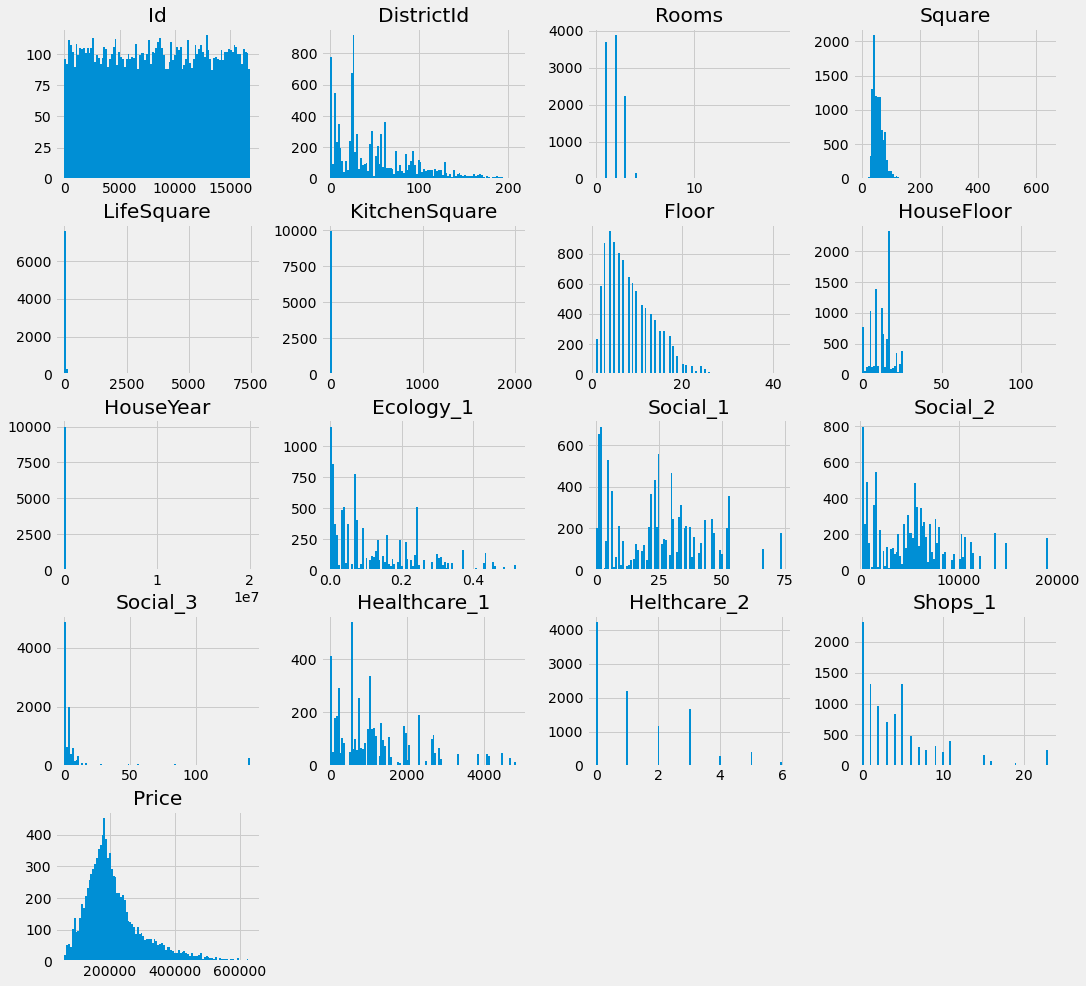

In [21]:
df.hist(bins=100, figsize=(16,16))
plt.show()

- Видно, что признаки 'LifeSquare', 'KitchenSquare', 'HouseYear' имеют выбросы.
- Атрибуты имеют разные масштабы.

### 1.3 Создание отложенной выборки (испытательного набора) <a class='anchor' id='val_set'>

В целях борьбы с переобучением сделаем стратифицированную выборку на основе площади объекта недвижимости, так как разумно предположить, что площадь является важным атрибутом для прогнозирования стоимости квартиры.

<AxesSubplot:>

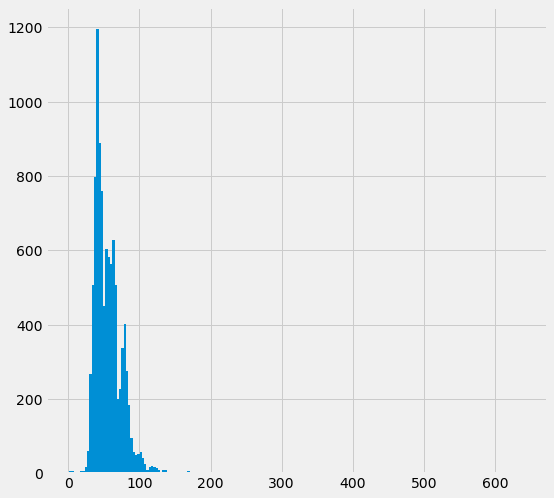

In [22]:
df.Square.hist(bins=200, figsize=(8,8))

Большинство значений площади квартир сгруппированы около 30 - 100 м^2 , но некторые выходят далеко за 120. Создадим атрибут категории дохода (0-30, 30-60, 60-90, 90-120, >120)

In [23]:
df['Square_cat'] = np.ceil(df.Square / 30)
df['Square_cat'].where(df['Square_cat'] < 5, 5.0, inplace=True)

In [24]:
df['Square_cat'].value_counts()

2.0    6249
3.0    3217
4.0     337
1.0     105
5.0      92
Name: Square_cat, dtype: int64

<AxesSubplot:>

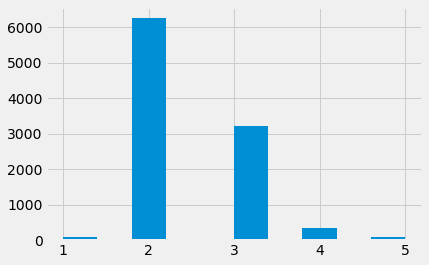

In [25]:
df['Square_cat'].hist()

In [26]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=28)
for train_index, test_index in split.split(df, df["Square_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [27]:
df["Square_cat"].value_counts() / len(df)

2.0    0.6249
3.0    0.3217
4.0    0.0337
1.0    0.0105
5.0    0.0092
Name: Square_cat, dtype: float64

In [28]:
def income_cat_proportions(data):
    return data["Square_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=28)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [29]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.0105,0.0105,0.0115,9.523810,0.000000
2.0,0.6249,0.6250,0.6305,0.896143,0.016003
3.0,0.3217,0.3220,0.3170,-1.460988,0.093255
4.0,0.0337,0.0335,0.0340,0.890208,-0.593472
5.0,0.0092,0.0090,0.0070,-23.913043,-2.173913


In [30]:
for set_ in (strat_train_set, strat_test_set, df):
    set_.drop("Square_cat", axis=1, inplace=True)

In [31]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

## 2. Базовое решение <a class='anchor' id='base_des'>

In [32]:
temp_df = strat_train_set.copy()
temp_val_df = strat_test_set.copy()

temp_test_df = test_df.copy()

### 2.1  Преобразование категориальных признаков <a class='anchor' id='dummies'>

In [33]:
binary_to_numbers = {'A': 0, 'B': 1}

for set_ in (temp_df, temp_val_df, temp_test_df):
    set_['Ecology_2'] = set_['Ecology_2'].replace(binary_to_numbers)
    set_['Ecology_3'] = set_['Ecology_3'].replace(binary_to_numbers)
    set_['Shops_2'] = set_['Shops_2'].replace(binary_to_numbers)

### 2.2 Замена пропущенных значений <a class='anchor' id='mis_val_base'>

In [34]:
for set_ in (temp_df, temp_val_df, temp_test_df):
    print('-----')
    print(set_.isna().sum()[set_.isna().sum() > 0])

-----
LifeSquare      1713
Healthcare_1    3850
dtype: int64
-----
LifeSquare      400
Healthcare_1    948
dtype: int64
-----
LifeSquare      1041
Healthcare_1    2377
dtype: int64


**признак 'LifeSquare_nan'**

In [35]:
for set_ in (temp_df, temp_val_df, temp_test_df):
    set_['LifeSquare_nan'] = set_['LifeSquare'].isna() * 1

    condition = (set_['LifeSquare'].isna())

    set_.loc[condition, 'LifeSquare'] = set_.loc[condition, 'Square'] \
                                            - set_.loc[condition, 'KitchenSquare'] - 3

**признак 'Healthcare_1'**

Заменять пропущенные значения признака 'Healthcare_1' будем путём прогнозирования с помощью модели, обученной на имеющихся данных

Для начала посмотрим как каждый числовой атрибут связан с признаком 'Healthcare_1'

In [36]:
corr_matrix = temp_df.corr()

corr_matrix['Healthcare_1'].sort_values(ascending=False)

Healthcare_1      1.000000
DistrictId        0.321909
Helthcare_2       0.212779
Social_3          0.144826
Price             0.139008
Social_1          0.073249
Shops_1           0.061946
Social_2          0.047577
Rooms             0.038983
KitchenSquare     0.005628
Id                0.003325
HouseYear        -0.013460
Shops_2          -0.025856
Ecology_2        -0.026598
Square           -0.048190
Ecology_1        -0.049598
LifeSquare       -0.074536
Ecology_3        -0.106122
HouseFloor       -0.150664
Floor            -0.156208
LifeSquare_nan   -0.175731
Name: Healthcare_1, dtype: float64

In [37]:
temp_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'LifeSquare_nan'],
      dtype='object')

Так как логично предположить, что значения признака Healthcare1 не зависят от таких атрибутов, как 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', оставим только те которые, скорее всего, помогут определить пропущенные значения

In [38]:
columns = ['Ecology_1',  'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 
           'Shops_1']

for set_ in (temp_df, temp_val_df, temp_test_df):
    set_['Health_nan'] = set_['Healthcare_1'].isna() * 1

# Датсеты, в которых надо заменить пропущенные значения:
health_train_null = temp_df[temp_df.Health_nan == 1][columns]
health_val_null = temp_val_df[temp_val_df.Health_nan == 1][columns]

health_test_null = temp_test_df[temp_test_df.Health_nan == 1][columns]

**Обучение модели**

In [39]:
X = temp_df[temp_df.Health_nan == 0].drop(columns='Healthcare_1')[columns]
y = temp_df[temp_df.Health_nan == 0]['Healthcare_1']

In [40]:
X.shape, y.shape

((4150, 6), (4150,))

In [41]:
dt_model = DecisionTreeRegressor(random_state=28)

In [42]:
cv_score_dt = cross_val_score(dt_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
cv_score_dt

array([0.99989186, 1.        , 0.99799141])

Результаты обнадёживающие, оставляем эту модель и рассчитываем с помощью неё пропущенные значения признака 'Healthcare_1'

In [43]:
dt_model.fit(X, y)

health_train_pred = dt_model.predict(health_train_null)
health_val_pred = dt_model.predict(health_val_null)

health_test_pred = dt_model.predict(health_test_null)

In [44]:
len(health_train_pred) + len(health_test_pred)

6227

In [45]:
feature_importances = pd.DataFrame(zip(X.columns, dt_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Social_3,0.309792
2,Social_2,0.256191
1,Social_1,0.154223
0,Ecology_1,0.126999
5,Shops_1,0.091970
4,Helthcare_2,0.060825


In [46]:
health_train_pred

array([ 320., 1183., 1183., ...,  320., 1547.,  350.])

In [47]:
health_train_null.index

Int64Index([5767, 4430, 5911, 6095, 7342, 5011,  757, 4819, 4496, 9638,
            ...
            3268, 9246, 8207, 3373, 6398, 5285, 7369, 4497,  284, 2194],
           dtype='int64', length=3850)

Заполняем пропущенные значения предсказанными моделью

In [48]:
health_train = pd.Series(health_train_pred, index=health_train_null.index)
health_val = pd.Series(health_val_pred, index=health_val_null.index)

health_test = pd.Series(health_test_pred, index=health_test_null.index)

In [49]:
temp_df['Healthcare_1'].fillna(health_train, inplace=True)
temp_val_df['Healthcare_1'].fillna(health_val, inplace=True)

temp_test_df['Healthcare_1'].fillna(health_test, inplace=True)

In [50]:
temp_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Health_nan
7579,2149,62,3.0,61.586468,46.508579,6.0,7,9.0,1979,0.037178,...,52,11217,1,2300.0,1,7,1,240804.697900,0,0
5837,3410,87,3.0,61.052434,45.511257,6.0,3,9.0,1978,0.000000,...,39,8647,0,810.0,0,5,1,284057.268711,0,0
9391,16187,6,3.0,82.136953,78.136953,1.0,3,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,1,214324.131855,1,0
313,14565,53,1.0,39.246823,35.246823,1.0,4,19.0,1977,0.049637,...,34,7759,0,229.0,1,3,1,203671.175291,1,0
5767,8694,8,2.0,44.966817,28.410299,6.0,3,9.0,1979,0.219006,...,28,6746,3,320.0,1,4,1,200029.483919,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3414,10283,19,3.0,77.469848,48.756854,9.0,3,6.0,1957,0.309479,...,35,7715,4,990.0,0,6,1,293459.205444,0,0
4497,12628,78,1.0,34.307988,22.568769,6.0,6,9.0,1973,0.219006,...,28,6746,3,320.0,1,4,1,88176.739773,0,1
284,1724,74,1.0,36.523264,32.523264,1.0,3,17.0,1977,0.075779,...,6,1437,3,1547.0,0,2,1,127047.787553,1,1
2670,16381,28,1.0,35.637992,19.382057,9.0,4,12.0,1965,0.118537,...,30,6207,1,1183.0,1,0,1,184243.992920,0,0


In [51]:
for set_ in (temp_df, temp_val_df, temp_test_df):
    print(set_.isna().sum().sum())

0
0
0


### 2.3  Построение базовой модели и её оценка <a class='anchor' id='base_mod'>

In [52]:
temp_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'LifeSquare_nan',
       'Health_nan'],
      dtype='object')

In [53]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare_nan',
       'Health_nan']

target_name = 'Price'

In [54]:
X_train = temp_df[feature_names]
y_train = temp_df[target_name]

X_valid = temp_val_df[feature_names]
y_valid = temp_val_df[target_name]

In [55]:
rf_model = RandomForestRegressor(random_state=28, criterion='mse', n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=28)

Train R2:	0.962
Test R2:	0.743


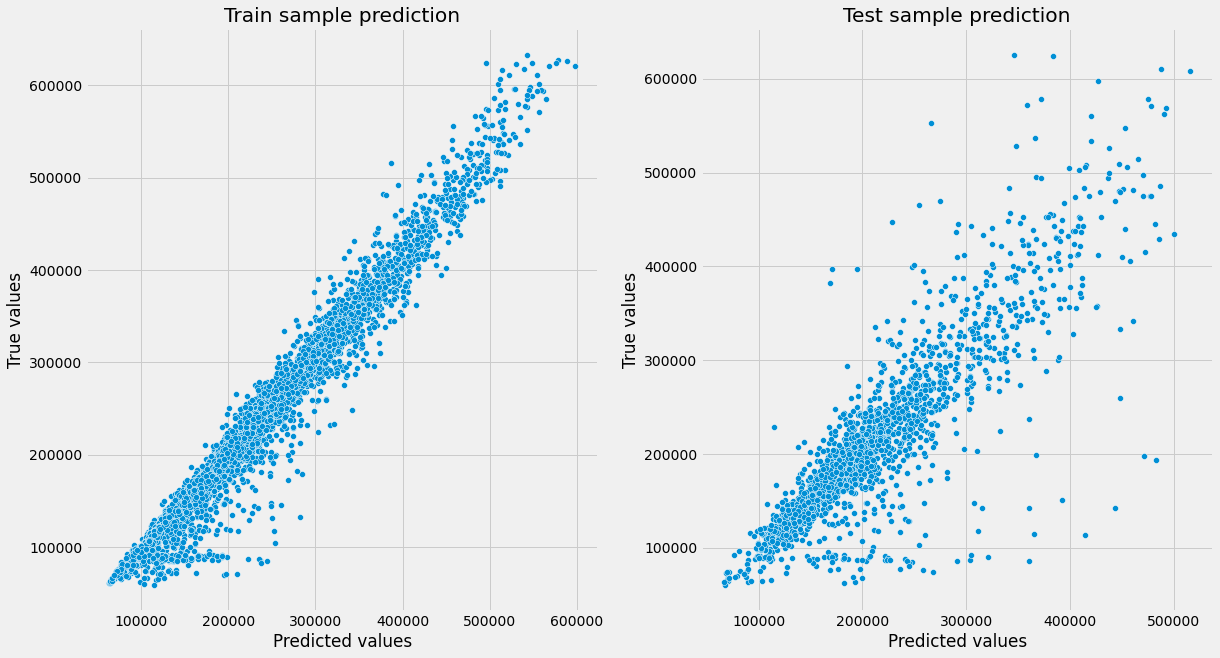

In [56]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Базовая модель получилась переобученной

In [57]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.398679
11,Social_1,0.133836
1,Rooms,0.062468
12,Social_2,0.058442
13,Social_3,0.053049
3,LifeSquare,0.040966
0,DistrictId,0.039920
8,Ecology_1,0.037998
7,HouseYear,0.036806
14,Healthcare_1,0.035854


In [58]:
temp_test_df.shape

(5000, 21)

In [59]:
temp_df.shape

(8000, 22)

In [60]:
submit = pd.read_csv(SUBM_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [61]:
predictions = rf_model.predict(temp_test_df[feature_names])
predictions

array([158208.22820022, 118854.05812624, 145961.52883372, ...,
       146449.40896298, 194562.4486068 , 257717.86324177])

In [62]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158208.228200
1,5925,118854.058126
2,960,145961.528834
3,3848,119482.414038
4,746,216239.143652


In [63]:
submit.to_csv('base_submit.csv', index=False, header = 1)

In [64]:
score_base_rf = 0.73156
print('Результат на kaggle (Public Score):', score_base_rf)

Результат на kaggle (Public Score): 0.73156


## 3. Разведочный анализ данных (EDA - Exploratory Data Analysis) <a class='anchor' id='eda'>

Стратегия замены пропущенных значений описана выше: [2.2 Замена пропущенных значений](#mis_val_base)

### 3.1 Обработка выбросов  <a class='anchor' id='outlier'>

In [65]:
strat_train_set['Id'] = strat_train_set['Id'].astype(str)
strat_train_set['DistrictId'] = strat_train_set['DistrictId'].astype(str)

In [66]:
columns = list(strat_train_set.dtypes[strat_train_set.dtypes != object].index)

Так как среднее арифметическое чувствительно к выбросам в отличии от медианы, то можно по разности между ними судить о том, много ли выбросов в признаке.

In [67]:
lst = []
for col in columns:
    mn = strat_train_set[col].mean()
    md = strat_train_set[col].median()
    lst.append([col, mn, md, mn / md])

In [68]:
mn_md_df = pd.DataFrame(lst, columns = ['Feature', 'mean', 'median', 'delta'])
mn_md_df.sort_values(by='delta', ascending=False)

,Feature,mean,median,delta
10,Social_3,7.915875,2.000000,3.957937
6,HouseYear,4491.296500,1977.000000,2.271774
7,Ecology_1,0.119954,0.075779,1.582949
13,Shops_1,4.177250,3.000000,1.392417
12,Helthcare_2,1.322375,1.000000,1.322375
11,Healthcare_1,1153.841446,900.000000,1.282046
4,Floor,8.530875,7.000000,1.218696
14,Price,213921.270870,191777.349232,1.115467
2,LifeSquare,36.265409,32.729196,1.108045
1,Square,56.314587,52.456064,1.073557


<AxesSubplot:>

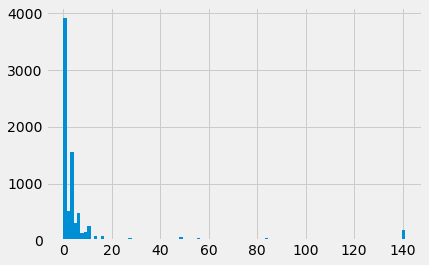

In [69]:
strat_train_set['Social_3'].hist(bins=100)

In [70]:
set(strat_train_set[strat_train_set['Social_3']==141].DistrictId)

{'104', '174', '189', '30', '4', '43'}

#### 3.1.1 HouseYear  <a class='anchor' id='HouseYear'>

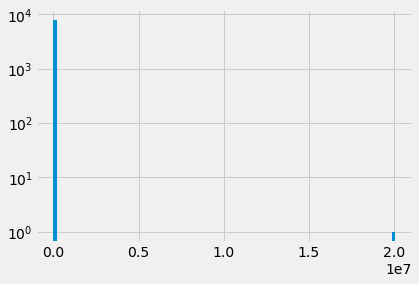

In [71]:
plt.hist(strat_train_set['HouseYear'], bins=100, log=True)
plt.show()

In [72]:
strat_train_set['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
6073        2020
5412        2020
1976        2020
          ...   
485         1917
7610        1916
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 8000, dtype: int64

In [73]:
strat_train_set[strat_train_set['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396


In [74]:
strat_train_set.loc[strat_train_set['HouseYear'] == 20052011, 'HouseYear'] = 2011
strat_train_set.loc[strat_train_set['HouseYear'] == 4968, 'HouseYear'] = 1968

#### 3.1.2 HouseFloor, Floor  <a class='anchor' id='Floor'>

In [75]:
strat_train_set['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        38.,  39.,  40.,  44.,  47.,  48.,  99., 117.])

In [76]:
strat_train_set[strat_train_set.HouseYear < 2000]['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  30.,  40.,  99., 117.])

В признаке 'HouseFloor' явно выбросы, особенно если учесть, что до 2003 самым высоким жилым зданием в Москве был Жилой дом на Котельнической набережной этажностью 32

In [77]:
strat_train_set['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [78]:
strat_train_set[strat_train_set.HouseYear < 2000]['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33], dtype=int64)

Значения признака 'Floor' выглядят адекватно. Ничего с ним делать не будем

In [79]:
(strat_train_set['Floor'] > strat_train_set['HouseFloor']).sum()

1468

Также придётся побороться со значениями в которых этаж, на котором находится квартира, выше этжности дома. В таких случаях будем просто заменять этажность дома на значение атрибута 'Floor'.

In [80]:
strat_train_set.loc[(strat_train_set['HouseFloor'] < 4) & (strat_train_set.HouseYear < 1960)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1026,7275,95,4.0,99.039161,71.575839,11.0,2,3.0,1942,0.000699,B,B,14,3369,24,4129.0,0,3,B,624156.003381
8434,11017,101,3.0,55.476882,37.698072,6.0,7,3.0,1959,0.225825,A,B,41,6558,7,1548.0,3,2,B,118410.974059
3391,1494,124,3.0,70.363852,47.861824,7.0,3,3.0,1952,0.169091,B,B,19,3856,10,NaN,2,5,B,259143.174754
2314,7505,2,2.0,53.055026,26.925534,7.0,5,3.0,1955,0.035145,B,B,42,9292,3,2620.0,0,3,B,212894.088951
5509,9454,22,2.0,50.072347,33.357161,7.0,3,3.0,1951,0.118537,B,B,30,6207,1,1183.0,1,0,B,193062.427929
2103,4671,124,2.0,61.875122,37.481412,9.0,2,3.0,1952,0.169091,B,B,19,3856,10,NaN,2,5,B,306525.883704
7106,7018,120,3.0,87.848494,56.589076,11.0,2,3.0,1931,0.341072,B,B,27,5664,48,2300.0,3,11,B,402075.431031


Врядли после 1960 года в Москве строили 1-, 2- этажные дома. А в этом наборе данных нет таких домов, построенных до 1960. Поэтому 1-, 2- этажные дома будем считать выбросом.

In [81]:
strat_train_set['HouseFloor_outlier'] = 0
strat_train_set.loc[strat_train_set['HouseFloor'] < 3, 'HouseFloor_outlier'] = 1
strat_train_set.loc[strat_train_set['Floor'] > strat_train_set['HouseFloor'], 'HouseFloor_outlier'] = 1
strat_train_set.loc[(strat_train_set.HouseYear < 2002) & (strat_train_set.HouseFloor > 32), 'HouseFloor_outlier'] = 1

Из выбросов сделаем пропущенные значения

In [82]:
strat_train_set.loc[strat_train_set['HouseFloor_outlier'] == 1, 'HouseFloor'] = np.nan

Заменять пропущенные значения средней этажностью домов такого же года постройки

In [83]:
strat_train_set['HouseFloor'].fillna(
   strat_train_set.groupby(['HouseYear'])['HouseFloor'].transform(lambda x: np.rint(x.mean())
    ), inplace=True)

# оставшиеся nan заменим значением 'Floor'
strat_train_set['HouseFloor'].fillna(strat_train_set.Floor, inplace=True)

In [84]:
(strat_train_set['Floor'] > strat_train_set['HouseFloor']).sum()

411

In [85]:
strat_train_set.loc[strat_train_set['Floor'] > strat_train_set['HouseFloor'], 
                    'HouseFloor'] = strat_train_set.Floor

In [86]:
(strat_train_set['Floor'] > strat_train_set['HouseFloor']).sum()

0

In [87]:
strat_train_set['HouseFloor'].isna().sum()

0

#### 3.1.3 KitchenSquare  <a class='anchor' id='KitchenSquare'> 

In [88]:
strat_train_set['KitchenSquare'].value_counts()

1.0       1976
8.0       1027
5.0        937
10.0       853
6.0        842
9.0        669
0.0        559
7.0        493
12.0       208
11.0       182
13.0        52
14.0        41
4.0         31
15.0        27
3.0         16
16.0        13
20.0        12
17.0         9
19.0         7
18.0         5
30.0         2
2.0          2
51.0         2
37.0         2
58.0         2
41.0         2
22.0         2
36.0         1
26.0         1
48.0         1
2014.0       1
40.0         1
23.0         1
35.0         1
123.0        1
78.0         1
54.0         1
27.0         1
29.0         1
25.0         1
62.0         1
31.0         1
63.0         1
112.0        1
21.0         1
42.0         1
75.0         1
39.0         1
73.0         1
1970.0       1
32.0         1
72.0         1
43.0         1
60.0         1
Name: KitchenSquare, dtype: int64

In [89]:
strat_train_set['KitchenSquare'].quantile(.975), strat_train_set['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [90]:
condition = (strat_train_set['KitchenSquare'].isna()) \
             | (strat_train_set['KitchenSquare'] > strat_train_set['KitchenSquare'].quantile(.975))
        
strat_train_set.loc[condition, 'KitchenSquare'] = strat_train_set['KitchenSquare'].median()

strat_train_set.loc[strat_train_set['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [91]:
strat_train_set['KitchenSquare'].value_counts()

3.0     2553
8.0     1027
6.0      995
5.0      937
10.0     853
9.0      669
7.0      493
12.0     208
11.0     182
13.0      52
4.0       31
Name: KitchenSquare, dtype: int64

#### 3.1.4 Rooms  <a class='anchor' id='Rooms'>

In [92]:
strat_train_set['Rooms'].value_counts()

2.0     3112
1.0     2967
3.0     1776
4.0      119
5.0       15
0.0        8
19.0       1
10.0       1
6.0        1
Name: Rooms, dtype: int64

In [93]:
strat_train_set['Rooms_outlier'] = 0
strat_train_set.loc[strat_train_set['Rooms'] == 0, 'Rooms_outlier'] = 1
strat_train_set.loc[strat_train_set['Rooms'] == 0, 'Rooms'] = 1

In [94]:
strat_train_set.loc[strat_train_set['Rooms'] > 5, 'Rooms_outlier'] = 1
strat_train_set.loc[strat_train_set['Rooms'] > 5, 'Rooms'] = 1

In [95]:
strat_train_set.loc[(strat_train_set['Rooms'] >= 4) & (strat_train_set['Square'] < 50), 'Rooms_outlier'] = 1
strat_train_set.loc[(strat_train_set['Rooms'] >= 4) & (strat_train_set['Square'] < 50), 'Rooms'] = 1

In [96]:
strat_train_set['Rooms'].value_counts()

2.0    3112
1.0    2980
3.0    1776
4.0     119
5.0      13
Name: Rooms, dtype: int64

#### 3.1.5 Square, LifeSquare  <a class='anchor' id='Square'>

Заменим пропущенные значения

In [97]:
strat_train_set['LifeSquare_nan'] = strat_train_set['LifeSquare'].isna() * 1

condition = (strat_train_set['LifeSquare'].isna()) \
             & (~strat_train_set['Square'].isna()) \
             & (~strat_train_set['KitchenSquare'].isna())
        
strat_train_set.loc[condition, 'LifeSquare'] = strat_train_set.loc[condition, 'Square'] \
                                            - strat_train_set.loc[condition, 'KitchenSquare'] - 5

In [98]:
strat_train_set['LifeSquare'].isna().sum()

0

In [99]:
strat_train_set[strat_train_set.LifeSquare > strat_train_set.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,Rooms_outlier,LifeSquare_nan
4496,15744,34,1.0,1.988943,2.642219,3.0,21,21.0,1977,0.069753,...,13670,4,NaN,1,11,B,458378.777006,1,0,0
161,6782,45,1.0,2.954309,5.257278,3.0,3,17.0,1977,0.195781,...,5212,6,NaN,3,2,B,438005.182323,1,0,0
5265,8386,27,2.0,62.067272,63.456181,10.0,3,17.0,2017,0.017647,...,469,0,NaN,0,0,B,178467.117151,0,0,0
4105,14322,1,2.0,62.411905,63.593900,3.0,24,24.0,1977,0.007122,...,264,0,NaN,0,1,B,209817.034644,0,0,0
7819,15840,1,1.0,43.764463,43.981998,3.0,2,18.0,2019,0.007122,...,264,0,NaN,0,1,B,142003.769940,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,2137,9,2.0,46.469859,50.703196,9.0,2,12.0,1966,0.310199,...,2748,1,NaN,0,0,B,159286.262162,0,0,0
8900,16136,6,2.0,52.534282,56.961780,3.0,17,17.0,2016,0.243205,...,1564,0,540.0,0,0,B,145428.851540,0,0,0
7419,5443,5,1.0,48.514321,49.922828,3.0,16,24.0,2017,0.150818,...,3433,4,2643.0,4,5,B,290958.689421,0,0,0
8863,9639,73,1.0,51.329603,53.966051,3.0,11,17.0,1977,0.042032,...,6856,84,1940.0,2,5,B,445920.620104,1,0,0


Странно, если площадь квартиры меньше 10. Такие данные будем считать выбросом, обрабатывать их будем следующем образом:
- если жилая площадь больше 10, то общую площадь заменим на сумму жилой, кухни + 5
- если жилая площадь меньше 10, то общую площадь заменим на медиану площади квартир того же года и такого же количества комнат

In [100]:
strat_train_set[strat_train_set.Square < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,Rooms_outlier,LifeSquare_nan
4496,15744,34,1.0,1.988943,2.642219,3.0,21,21.0,1977,0.069753,...,13670,4,NaN,1,11,B,458378.777006,1,0,0
161,6782,45,1.0,2.954309,5.257278,3.0,3,17.0,1977,0.195781,...,5212,6,NaN,3,2,B,438005.182323,1,0,0
9869,3224,27,1.0,2.377248,0.873147,3.0,1,17.0,1977,0.017647,...,469,0,NaN,0,0,B,126596.941798,1,1,0
7470,14786,1,1.0,1.136859,4.525736,3.0,3,17.0,1977,0.007122,...,264,0,NaN,0,1,B,181434.825589,1,0,0
9067,13265,1,3.0,4.823679,79.767964,3.0,6,17.0,1977,0.007122,...,264,0,NaN,0,1,B,237716.681261,0,0,0
7033,1748,88,2.0,5.497061,67.628717,3.0,24,24.0,1977,0.127376,...,8429,3,NaN,3,9,B,412511.088764,1,0,0
328,4504,27,3.0,4.390331,5.610772,3.0,8,19.0,2016,0.211401,...,1892,0,NaN,0,1,B,161379.067034,0,0,0
8805,10527,27,1.0,4.380726,40.805837,3.0,10,17.0,2013,0.211401,...,1892,0,NaN,0,1,B,97560.720383,0,0,0
1401,9487,5,1.0,5.129222,5.549458,3.0,1,17.0,1977,0.150818,...,3433,4,2643.0,4,5,B,369472.403061,1,0,0
5009,11526,27,1.0,4.633498,1.969969,3.0,18,18.0,1977,0.011654,...,915,0,NaN,0,0,B,107604.269441,1,0,0


In [101]:
strat_train_set['Square_outlier'] = 0

In [102]:
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] > 10), 'Square_outlier'] = 1
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] > 10), 'Square'] = \
                          strat_train_set['LifeSquare']  +  strat_train_set['KitchenSquare'] + 5

In [103]:
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] <= 10), 'Square_outlier'] = 1
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] <= 10), 'Square'] = np.nan

strat_train_set['Square'].fillna(
   strat_train_set.groupby(['HouseYear', 'Rooms'])['Square'].transform(lambda x: x.median()), inplace=True)

In [104]:
strat_train_set[strat_train_set['Square_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,Rooms_outlier,LifeSquare_nan,Square_outlier
4496,15744,34,1.0,42.706178,2.642219,3.0,21,21.0,1977,0.069753,...,4,NaN,1,11,B,458378.777006,1,0,0,1
161,6782,45,1.0,42.706178,5.257278,3.0,3,17.0,1977,0.195781,...,6,NaN,3,2,B,438005.182323,1,0,0,1
9869,3224,27,1.0,42.706178,0.873147,3.0,1,17.0,1977,0.017647,...,0,NaN,0,0,B,126596.941798,1,1,0,1
7470,14786,1,1.0,42.706178,4.525736,3.0,3,17.0,1977,0.007122,...,0,NaN,0,1,B,181434.825589,1,0,0,1
9067,13265,1,3.0,87.767964,79.767964,3.0,6,17.0,1977,0.007122,...,0,NaN,0,1,B,237716.681261,0,0,0,1
7033,1748,88,2.0,75.628717,67.628717,3.0,24,24.0,1977,0.127376,...,3,NaN,3,9,B,412511.088764,1,0,0,1
328,4504,27,3.0,83.616930,5.610772,3.0,8,19.0,2016,0.211401,...,0,NaN,0,1,B,161379.067034,0,0,0,1
8805,10527,27,1.0,48.805837,40.805837,3.0,10,17.0,2013,0.211401,...,0,NaN,0,1,B,97560.720383,0,0,0,1
1401,9487,5,1.0,42.706178,5.549458,3.0,1,17.0,1977,0.150818,...,4,2643.0,4,5,B,369472.403061,1,0,0,1
5009,11526,27,1.0,42.706178,1.969969,3.0,18,18.0,1977,0.011654,...,0,NaN,0,0,B,107604.269441,1,0,0,1


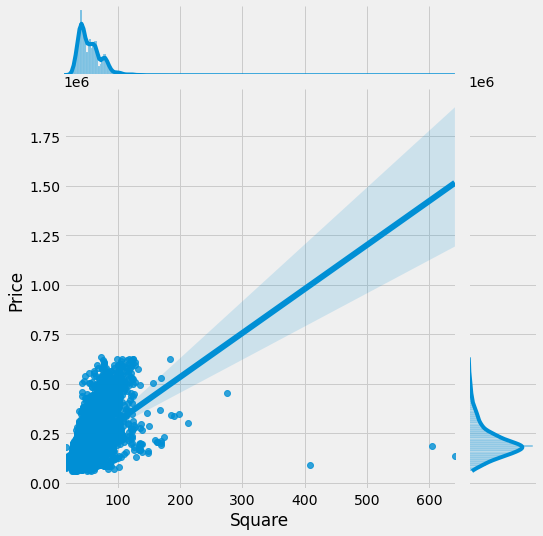

In [105]:
grid = sns.jointplot(strat_train_set['Square'], strat_train_set['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Судя по графику рпаспределения площади от стоимости квартир есть выбросы, когда площадь большая, а стоимость низкая. Такие значения площади поделим на 10 (реализовано ниже в class DataPreprocessing)

In [106]:
strat_train_set[(strat_train_set.Square > 130) & (strat_train_set.HouseYear > 1960) & (strat_train_set.HouseYear < 1990) & (strat_train_set.Rooms < 3)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier,Rooms_outlier,LifeSquare_nan,Square_outlier
9037,16204,23,1.0,160.647588,152.647588,3.0,3,3.0,1977,0.014073,...,0,NaN,0,0,B,217874.997452,0,0,1,0
726,28,9,2.0,604.705972,596.705972,3.0,17,18.0,1977,0.161532,...,1,30.0,2,4,B,187717.242538,0,0,1,0
6909,14662,23,1.0,148.179026,140.179026,3.0,1,17.0,1977,0.014073,...,0,NaN,0,0,B,160902.854650,1,0,1,0


Если в 1- и 2- комнатных квартирах постройки 2-й половины советского периода площадь > 130, у такой площади возьмём остаток от деления на 100 (реализовано ниже в class DataPreprocessing).

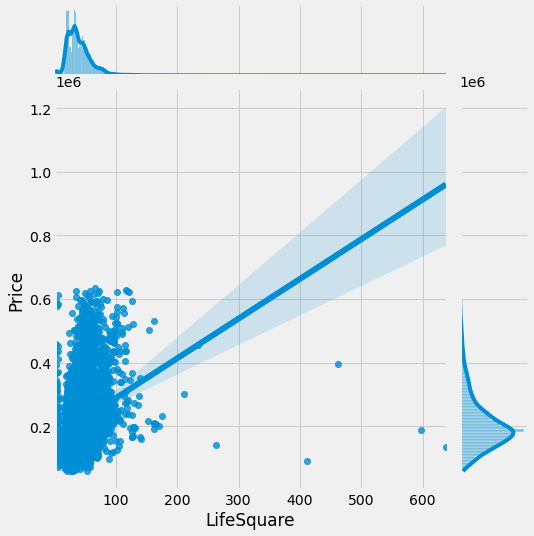

In [107]:
grid = sns.jointplot(strat_train_set['LifeSquare'], strat_train_set['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Есть квартиры с неправдоподбной жилой площадью. Если LifeSquare < 0.25 * Square, то жилую площадь заменим на 0,6 * Square. Также поступим, если жилая площадь больше или равна общей (реализовано ниже в class DataPreprocessing), что уберёт выбросы справа на графике выше.

In [108]:
strat_train_set[strat_train_set['LifeSquare'] < 0.25 * strat_train_set['Square']].LifeSquare.sort_values()

3113     0.370619
1829     0.641822
9869     0.873147
6882     1.049867
2687     1.104689
          ...    
3549     5.949812
6244     5.954610
6263     5.996579
2180    11.168019
244     22.630373
Name: LifeSquare, Length: 167, dtype: float64

In [109]:
strat_train_set.loc[strat_train_set['LifeSquare'] < 0.25 * strat_train_set['Square'], 'LifeSquare_nan'] = 1
strat_train_set.loc[strat_train_set['LifeSquare'] < 0.25 * strat_train_set['Square'], 'LifeSquare'] = \
                                                            0.6 * strat_train_set['Square']

### 3.2 Создание класса DataPreprocessing  <a class='anchor' id='DataPreprocessing'>

In [110]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.dt_model = DecisionTreeRegressor(random_state=28)
        self.columns = ['Ecology_1',  'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        X['Health_nan'] = X['Healthcare_1'].isna() * 1
        
        # обучение модели длля прогнозирования признака 'Healthcare_1'       
        X_ = X[X.Health_nan == 0].drop(columns='Healthcare_1')[self.columns]
        y_ = X[X.Health_nan == 0]['Healthcare_1']
        self.dt_model.fit(X_, y_)
        
    def transform(self, X):
        """Трансформация данных"""

        # HouseYear
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2011
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 5
        
        # Square
        X['Square_outlier'] = 0

        X.loc[(X['Square'] < 10) & (X['LifeSquare'] > 10), 'Square_outlier'] = 1
        X.loc[(X['Square'] < 10) & (X['LifeSquare'] > 10), 'Square'] = \
                          X['LifeSquare']  +  X['KitchenSquare'] + 5
        
        X.loc[(X['Square'] < 10) & (X['LifeSquare'] <= 10), 'Square_outlier'] = 1
        X.loc[(X['Square'] < 10) & (X['LifeSquare'] <= 10), 'Square'] = np.nan

        X['Square'].fillna(
        X.groupby(['HouseYear', 'Rooms'])['Square'].transform(lambda x: x.median()), inplace=True)
        
        X.loc[X['Square'] > 280, 'Square_outlier'] = 1
        X.loc[X['Square'] > 280, 'LifeSquare'] = X['LifeSquare'] / 10
        X.loc[X['Square'] > 280, 'Square'] = X['Square'] / 10
        
        X.loc[(X.Square > 130) & (X.HouseYear > 1960) & (X.HouseYear < 1990) & (X.Rooms < 3), 'Square_outlier'] = 1
        X.loc[(X.Square > 130) & (X.HouseYear > 1960) & (X.HouseYear < 1990) & (X.Rooms < 3), 'LifeSquare'] = X['LifeSquare'] % 100 
        X.loc[(X.Square > 130) & (X.HouseYear > 1960) & (X.HouseYear < 1990) & (X.Rooms < 3), 'Square'] = X['Square'] % 100 
        
        X['Square'] = np.rint(X['Square'])
        
        # LifeSquare again
        X.loc[X['LifeSquare'] < 0.25 * X['Square'], 'LifeSquare_nan'] = 1
        X.loc[X['LifeSquare'] < 0.25 * X['Square'], 'LifeSquare'] = 0.6 * X['Square']
        
        X.loc[X.LifeSquare - X.Square >= 0, 'LifeSquare'] = 0.6 * X['Square']
        
        X['LifeSquare'] = np.rint(X['LifeSquare'])
                
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[X['Rooms'] == 0, 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        
        X.loc[X['Rooms'] > 5, 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = 1
        
        X.loc[(X['Rooms'] >= 4) & (X['Square'] < 50), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] >= 4) & (X['Square'] < 50), 'Rooms'] = 1
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] < 3, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[(X.HouseYear < 2002) & (X.HouseFloor > 32), 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor_outlier'] == 1, 'HouseFloor'] = np.nan
        
        X['HouseFloor'].fillna(
        X.groupby(['HouseYear'])['HouseFloor'].transform(lambda x: np.rint(x.median())), inplace=True)
        X['HouseFloor'].fillna(X.Floor, inplace=True)
        X.loc[X['Floor'] > X['HouseFloor'],'HouseFloor'] = X.Floor
        
        # Healthcare_1
        X['Health_nan'] = X['Healthcare_1'].isna() * 1
        health_train_null = X[X.Health_nan == 1][self.columns]
        
        health_train_pred = self.dt_model.predict(health_train_null)    
        
        health_train = pd.Series(health_train_pred, index=health_train_null.index)
        
        X['Healthcare_1'].fillna(health_train, inplace=True)

#        X.fillna(self.medians, inplace=True)
        
        return X

In [111]:
def X_and_y(train_path=DATASET_PATH, test=TEST_PATH, target_drop=True):
    df = pd.read_csv(train_path)
    test_df = pd.read_csv(test)
    
    binary_to_numbers = {'A': 0, 'B': 1}

    for set_ in (df, test_df):
        set_['Ecology_2'] = set_['Ecology_2'].replace(binary_to_numbers)
        set_['Ecology_3'] = set_['Ecology_3'].replace(binary_to_numbers)
        set_['Shops_2'] = set_['Shops_2'].replace(binary_to_numbers)

    df['Square_cat'] = np.ceil(df.Square / 30)
    df['Square_cat'].where(df['Square_cat'] < 5, 5.0, inplace=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=28)
    for train_index, test_index in split.split(df, df["Square_cat"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
    for set_ in (strat_train_set, strat_test_set, df):
        set_.drop("Square_cat", axis=1, inplace=True)
    
    preprocessor = DataPreprocessing()
    preprocessor.fit(strat_train_set)
    
    col = ['Id']
    if target_drop == True:
        col = ['Price', 'Id']
        
    X_train = preprocessor.transform(strat_train_set.drop(columns=col))
    X_valid = preprocessor.transform(strat_test_set.drop(columns=col))
    test_df = preprocessor.transform(test_df.drop(columns=['Id']))
        
    y_train = strat_train_set['Price']
    y_valid = strat_test_set['Price']
    
    print('X_train, y_train, X_valid, y_valid, test_df shape', X_train.shape, y_train.shape,
          X_valid.shape, y_valid.shape, test_df.shape)
    return X_train, y_train, X_valid, y_valid, test_df

In [112]:
X_train, y_train, X_valid, y_valid, test_df = X_and_y()

X_train, y_train, X_valid, y_valid, test_df shape (8000, 23) (8000,) (2000, 23) (2000,) (5000, 23)


### 3.3 Исследование признака 'DistrictId'  <a class='anchor' id='DistrictId'>

#### 3.3.1 Обзор 'DistrictId'  <a class='anchor' id='DistrictId_re'>

In [113]:
X_train['DistrictId'].value_counts()

27     680
1      525
23     464
6      421
9      228
      ... 
201      1
199      1
209      1
174      1
205      1
Name: DistrictId, Length: 204, dtype: int64

In [114]:
X_train['DistrictId'].unique()

array([ 62,  87,   6,  53,   8,  28,   5,  30,  63,  67,  47,  21, 101,
        46,  23, 138,   9,  26,  88,  34,  48,  27,   1, 103,  10,  54,
       121,  61, 107,  85,  58,  65, 100,  32,  41,  22,  59, 146,  45,
       160,  98,  74,  37,  89, 192,  64,  24,  79,  94,  90,  13, 111,
       139,  57,  49,  56,  12, 108,  39,  25, 127,  99,  91,  42,  17,
       167, 157, 188, 169,   7, 114, 110,  96, 179,   3, 140, 106, 116,
       120,   2,   4, 163,  75,  51, 105,  77,   0, 181, 109,  52, 119,
        15,  35,  11, 132,  38, 130,  78, 134, 104, 129, 112,  18,  20,
        93,  55, 187,  86, 166,  44, 183, 170, 123,  29, 148, 194,  80,
        31, 177,  69,  66, 113, 125, 141, 145,  84,  16, 131, 128, 147,
        70,  33,  92,  36, 164,  40, 193, 175, 126, 122,  83,  81,  19,
        82, 152, 158, 124, 171,  43,  73,  97,  72,  95, 136,  14, 154,
       161, 142, 144, 168, 182, 118,  68, 149,  71,  60, 143, 155, 162,
       135,  76, 178, 184, 151, 165, 190, 173, 102, 189, 176, 13

Введём новый признак 'price_m' - стоимость квадратного метра, и посмотрим какая средняя стоимость квдаратного метра жилья в каждом районе

In [115]:
X_train['pr_m'] = y_train / X_train.Square

In [116]:
Distr = []
for d in X_train.DistrictId.unique():
    Distr.append([d, X_train.pr_m[X_train.DistrictId == d].median(), 
                  X_train.pr_m[X_train.DistrictId == d].count()])

Distr_df = pd.DataFrame(Distr, columns = ['DistrictId', 'price_med', 'cnt'])
Distr_df['DistrictId'] = Distr_df['DistrictId'].astype(int)
Distr_df = Distr_df.sort_values(by = 'DistrictId', ascending=True)
Distr_df.reset_index(inplace=True)
Distr_df

,index,DistrictId,price_med,cnt
0,86,0,4048.300117,41
1,22,1,3250.225836,525
2,79,2,4468.303469,58
3,74,3,3897.806371,69
4,80,4,5661.935613,9
...,...,...,...,...
199,189,202,7499.637427,2
200,203,205,5127.943400,1
201,197,207,5534.888433,1
202,201,208,8092.997906,1


Построим график зависимости средней стоимости квадратного метра от района, при если в районе 1 или 2 квартиры окрасим их в другой цвет

In [117]:
Distr_df['bin_cat'] = Distr_df['cnt'].where(Distr_df['cnt'] < 3, 3)
Distr_df

,index,DistrictId,price_med,cnt,bin_cat
0,86,0,4048.300117,41,3
1,22,1,3250.225836,525,3
2,79,2,4468.303469,58,3
3,74,3,3897.806371,69,3
4,80,4,5661.935613,9,3
...,...,...,...,...,...
199,189,202,7499.637427,2,2
200,203,205,5127.943400,1,1
201,197,207,5534.888433,1,1
202,201,208,8092.997906,1,1


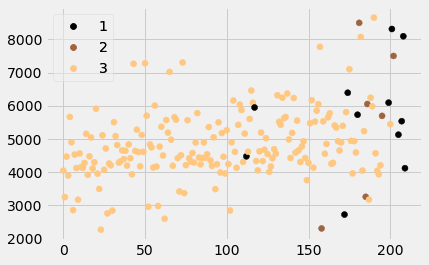

In [118]:
fig, ax = plt.subplots()

scatter = ax.scatter(Distr_df['DistrictId'], Distr_df['price_med'], c=Distr_df.bin_cat, 
            cmap=plt.cm.get_cmap('copper'))
legend1 = ax.legend(*scatter.legend_elements(), framealpha=0.3)
ax.add_artist(legend1)
plt.show()

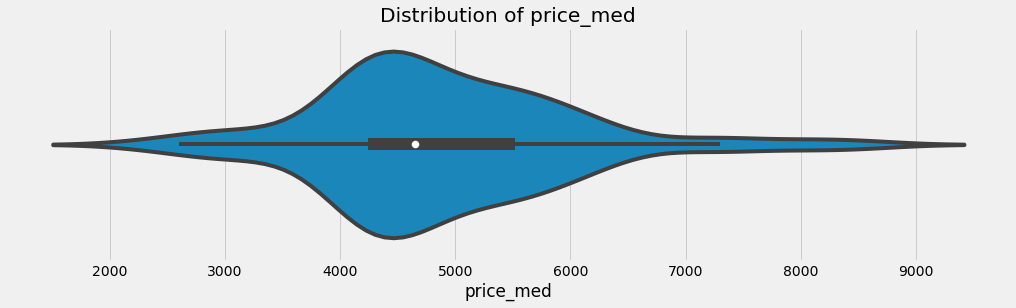

In [119]:
plt.figure(figsize=(16, 4))

#sns.boxplot(Distr_df['price_med'], whis=1.5)
sns.violinplot(Distr_df['price_med'])

plt.xlabel('price_med')
plt.title('Distribution of price_med')
plt.show()

In [120]:
Distr_df.price_med.describe()

count     204.000000
mean     4883.828492
std      1106.449333
min      2266.946746
25%      4238.170330
50%      4653.809722
75%      5517.587731
max      8653.762354
Name: price_med, dtype: float64

Большинство районов характеризуются средним ценовым диаппазоном (~ 4200 - 5500 за квадрат), но явно выделяются районы с более дорогим жильём и более низким.

Можно попробовать создать новый признак на базе 'Distr_id' с помощью кластеризации, поделив районы на 3 категории исходя из стоимости квадратного метра

#### 3.3.2 Создание нового признака 'distr_cat' <a class='anchor' id='distr_cat'>

In [121]:
def price_to_cat(X):

    X['distr_cat'] = 0

    X.loc[X['price_med'] <= 4000, 'distr_cat'] = 1
    X.loc[(X['price_med'] > 4000) & (X['price_med'] <= 6000), 'distr_cat'] = 2
    X.loc[(X['price_med'] > 6000), 'distr_cat'] = 3

    return X

In [122]:
Distr_df = price_to_cat(Distr_df)
Distr_df.head(5)

,index,DistrictId,price_med,cnt,bin_cat,distr_cat
0,86,0,4048.300117,41,3,2
1,22,1,3250.225836,525,3,1
2,79,2,4468.303469,58,3,2
3,74,3,3897.806371,69,3,1
4,80,4,5661.935613,9,3,2


In [123]:
X_train = X_train.merge(Distr_df[['DistrictId', 'distr_cat']], on=['DistrictId'], how='left')
X_train.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Health_nan,LifeSquare_nan,Square_outlier,Rooms_outlier,HouseFloor_outlier,pr_m,distr_cat
0,62,3.0,62.0,47.0,6.0,7,9.0,1979,0.037178,1,...,1,7,1,0,0,0,0,0,3883.946740,1
1,87,3.0,61.0,46.0,6.0,3,9.0,1978,0.000000,1,...,0,5,1,0,0,0,0,0,4656.676536,2
2,6,3.0,82.0,76.0,3.0,3,17.0,1977,0.243205,1,...,0,0,1,0,1,0,0,0,2613.708925,1
3,53,1.0,39.0,33.0,3.0,4,19.0,1977,0.049637,1,...,1,3,1,0,1,0,0,0,5222.337828,2
4,8,2.0,45.0,28.0,6.0,3,9.0,1979,0.219006,1,...,1,4,1,1,0,0,0,0,4445.099643,2


#### 3.3.2 Обучение модели для прогнозирования признака 'distr_cat' <a class='anchor' id='distr_cat_pred'>

**Обучение и кросс-валидация**

In [124]:
X = X_train.drop(columns=['pr_m', 'distr_cat'])
y = X_train['distr_cat']

X.shape, y.shape

((8000, 23), (8000,))

In [125]:
rf_model = RandomForestClassifier(random_state=28)

In [126]:
cv_score_rf = cross_validate(rf_model, X, y, scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted'],
                                                       cv=KFold(n_splits=3, shuffle=True, random_state=28))
cv_score_rf

{'fit_time': array([0.51464987, 0.51062822, 0.53130364]),
 'score_time': array([0.10800529, 0.08578467, 0.09477282]),
 'test_accuracy': array([0.98387702, 0.98012748, 0.97861965]),
 'test_balanced_accuracy': array([0.88510991, 0.84365536, 0.87493784]),
 'test_roc_auc_ovr_weighted': array([0.99919722, 0.99777799, 0.99810926])}

Результаты приемлимы, оставим эту модель и посмотрим какие будут результаты на отложенной выборке

In [127]:
rf_model = RandomForestClassifier(random_state=28, n_jobs=-1)
rf_model.fit(X, y)

RandomForestClassifier(n_jobs=-1, random_state=28)

**Оценка модели на отложенной выборке**

In [128]:
X_valid = X_valid.merge(Distr_df[['DistrictId', 'distr_cat']], on=['DistrictId'], how='left')
X_valid.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Square_outlier,Rooms_outlier,HouseFloor_outlier,Health_nan,distr_cat
0,83,2.0,55.0,35.0,9.0,8,17.0,1987,0.007720,1,...,2672.0,0,4,1,0,0,0,0,1,2.0
1,28,2.0,45.0,29.0,5.0,3,5.0,1977,0.118537,1,...,1183.0,1,0,1,0,0,0,0,0,2.0
2,23,1.0,41.0,35.0,3.0,11,17.0,1977,0.075779,1,...,1547.0,0,2,1,1,0,0,0,1,1.0
3,85,1.0,30.0,16.0,5.0,11,12.0,1981,0.037178,1,...,2300.0,1,7,1,0,0,0,1,0,2.0
4,167,2.0,52.0,29.0,8.0,5,5.0,1962,0.050272,1,...,1020.0,0,3,1,0,0,0,0,0,2.0


In [129]:
X_valid.distr_cat.fillna(1, inplace=True)

In [130]:
X_v = X_valid.drop(columns='distr_cat')
y_v = X_valid['distr_cat']

X_v.shape, y_v.shape

((2000, 23), (2000,))

In [131]:
val_pred = rf_model.predict_proba(X_v)
y_t = rf_model.predict(X_v)

In [132]:
np.array(y_v)

array([2., 2., 1., ..., 2., 2., 2.])

In [133]:
def class_score(y, y_pred_proba, y_pred):
    print('accuracy score:', accuracy_score(y, y_pred))
    print('balanced_accuracy_score:', balanced_accuracy_score(y, y_pred))
    print('roc_auc_score_ovr_weighted:', roc_auc_score(y, y_pred_proba, average='weighted', multi_class='ovr'))
    print('roc_auc_score_ovo_macro:', roc_auc_score(y, y_pred_proba, average='macro', multi_class='ovo'))

In [134]:
class_score(y_v, val_pred, y_t)

accuracy score: 0.9795
balanced_accuracy_score: 0.8957571977314022
roc_auc_score_ovr_weighted: 0.998020268485064
roc_auc_score_ovo_macro: 0.9955880716996478


На отложенной выборке метрики показывают практически теже результаты

**Отбор признаков**

Посмотрим на важность признаков и выберем лучшие из них

In [135]:
feature_importances = pd.DataFrame(zip(X.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Social_2,0.154555
11,Social_1,0.150627
0,DistrictId,0.127952
14,Healthcare_1,0.098961
13,Social_3,0.086982
16,Shops_1,0.074148
15,Helthcare_2,0.067739
8,Ecology_1,0.064317
4,KitchenSquare,0.059550
7,HouseYear,0.023913


In [136]:
columns = feature_importances[feature_importances.importance > 0.06]['feature_name']
columns

0       DistrictId
8        Ecology_1
11        Social_1
12        Social_2
13        Social_3
14    Healthcare_1
15     Helthcare_2
16         Shops_1
Name: feature_name, dtype: object

In [137]:
cv_score_rf = cross_validate(rf_model, X[columns], y, scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted'],
                                                       cv=KFold(n_splits=3, shuffle=True, random_state=28))
cv_score_rf

{'fit_time': array([2.05420017, 0.14660811, 0.15059733]),
 'score_time': array([0.07679367, 0.08577108, 0.0787878 ]),
 'test_accuracy': array([0.99700037, 0.99625047, 0.99737434]),
 'test_balanced_accuracy': array([0.97906763, 0.98094028, 0.99230628]),
 'test_roc_auc_ovr_weighted': array([0.99990786, 0.99927304, 0.99993753])}

In [138]:
rf_model = RandomForestClassifier(random_state=28, n_jobs=-1)
rf_model.fit(X[columns], y)

RandomForestClassifier(n_jobs=-1, random_state=28)

In [139]:
class_score(y_v, rf_model.predict_proba(X_v[columns]), rf_model.predict(X_v[columns]))

accuracy score: 0.996
balanced_accuracy_score: 0.9903099125973366
roc_auc_score_ovr_weighted: 0.9997058833155947
roc_auc_score_ovo_macro: 0.9995773458332075


Результаты улучшились, поэтому будем использовать 8 лучших признаков для предсказания категории района

### 3.4 Матрица корреляций <a class='anchor' id='corr'>

In [140]:
X_train, y_train, X_valid, y_valid, test_df = X_and_y(target_drop=False)

X_train, y_train, X_valid, y_valid, test_df shape (8000, 24) (8000,) (2000, 24) (2000,) (5000, 23)


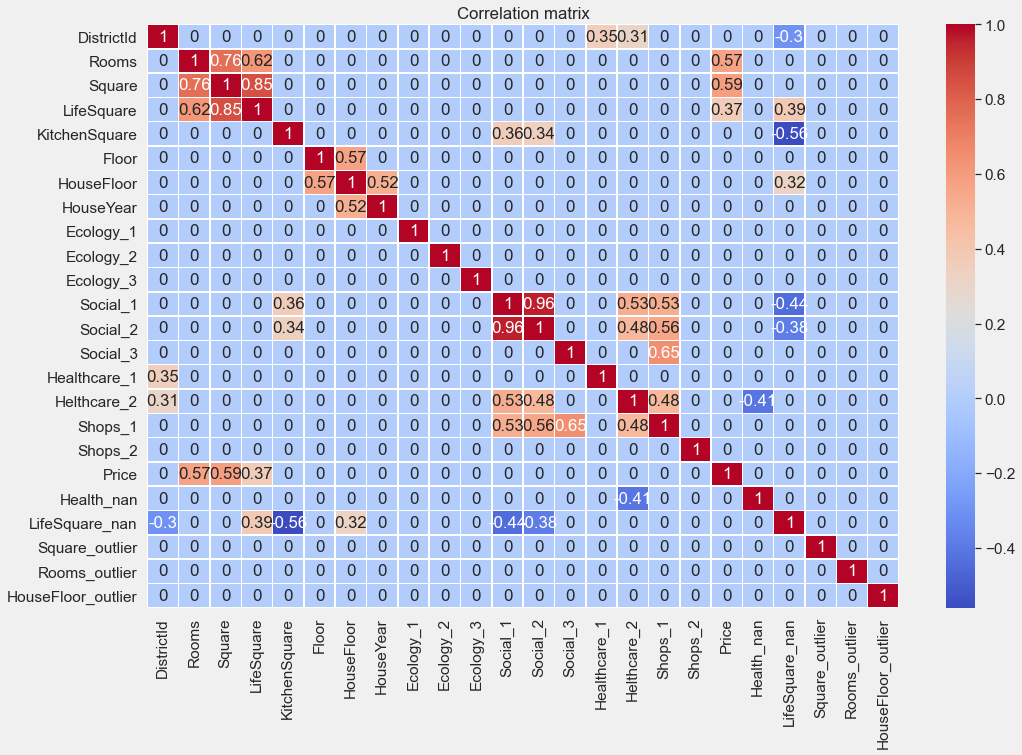

In [141]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [142]:
corr_matrix['Price'].sort_values(ascending=False)

Price                 1.00
Square                0.59
Rooms                 0.57
LifeSquare            0.37
HouseFloor_outlier    0.00
Ecology_3             0.00
KitchenSquare         0.00
Floor                 0.00
HouseFloor            0.00
HouseYear             0.00
Ecology_1             0.00
Ecology_2             0.00
Social_1              0.00
Rooms_outlier         0.00
Social_2              0.00
Social_3              0.00
Healthcare_1          0.00
Helthcare_2           0.00
Shops_1               0.00
Shops_2               0.00
Health_nan            0.00
LifeSquare_nan        0.00
Square_outlier        0.00
DistrictId            0.00
Name: Price, dtype: float64

**Графики зависимостей целевой переменной от некоторых признаков**

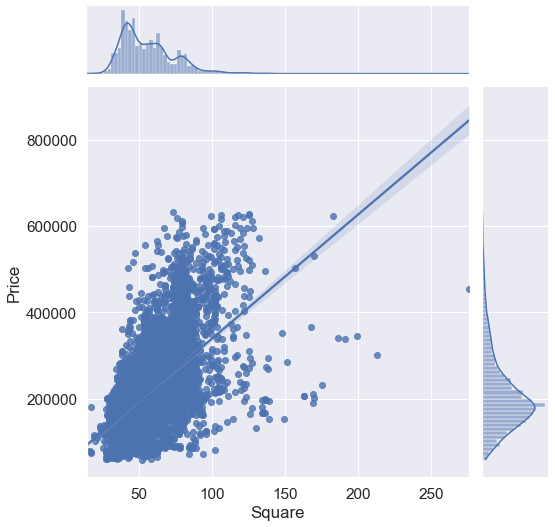

In [143]:
grid = sns.jointplot(X_train['Square'], X_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

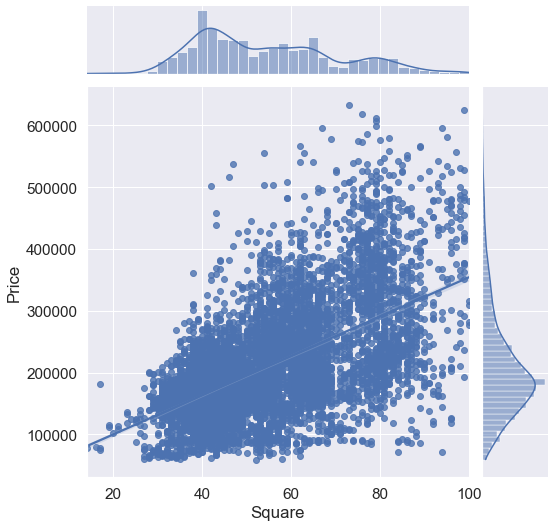

In [144]:
grid = sns.jointplot(X_train[X_train.Square <= 100]['Square'], X_train[X_train.Square <= 100]['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

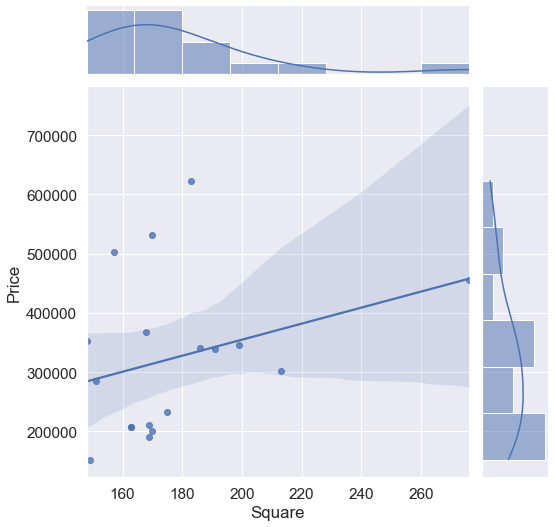

In [145]:
grid = sns.jointplot(X_train[X_train.Square > 140]['Square'], X_train[X_train.Square > 140]['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

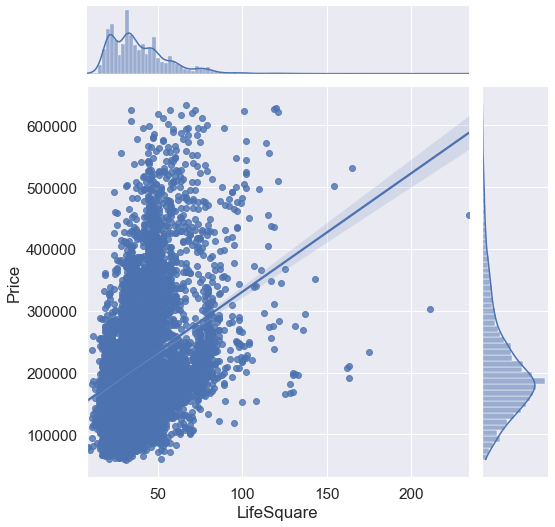

In [146]:
grid = sns.jointplot(X_train['LifeSquare'], X_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

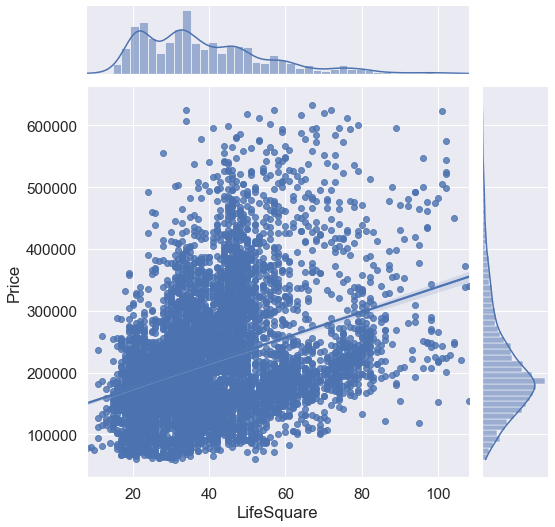

In [147]:
grid = sns.jointplot(X_train[X_train['LifeSquare'] < 110]['LifeSquare'], X_train[X_train['LifeSquare'] < 110]['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

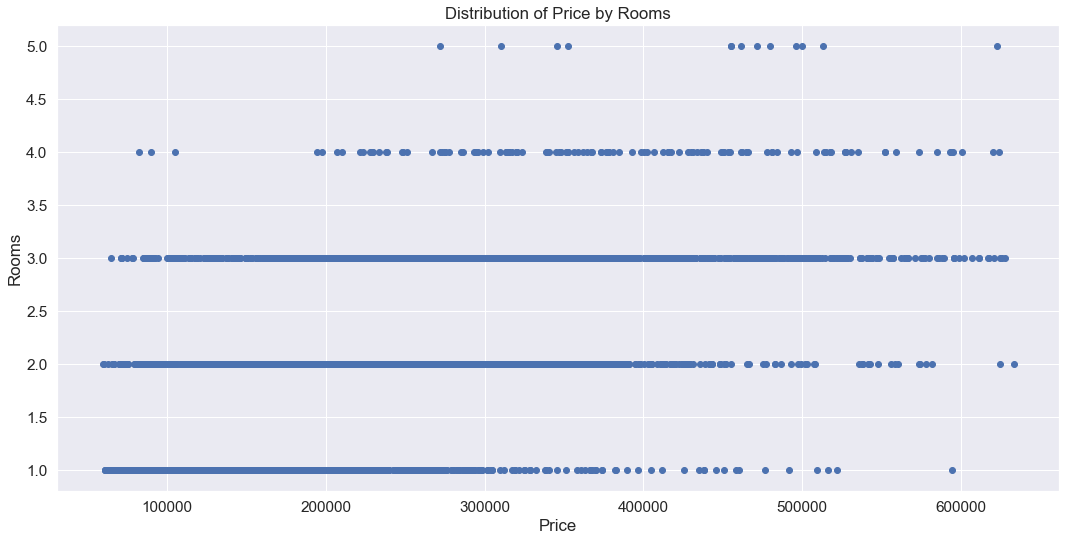

In [148]:
plt.figure(figsize=(16, 8))

plt.scatter(X_train['Price'], X_train['Rooms'])

plt.xlabel('Price')
plt.ylabel('Rooms')
plt.title('Distribution of Price by Rooms')
plt.show()

### 4. Построение новых признаков  <a class='anchor' id='feature'>

In [149]:
X_train, y_train, X_valid, y_valid, test_df = X_and_y()

X_train, y_train, X_valid, y_valid, test_df shape (8000, 23) (8000,) (2000, 23) (2000,) (5000, 23)


Создание нового признака на основе 'DistrictID' описано в [3.3.2 Создание нового признака 'distr_cat'](#distr_cat)

In [150]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.house_year_max = None
        self.district_size = None
        self.rf_model = RandomForestClassifier(random_state=28, n_jobs=-1)
        self.columns = ['Ecology_1',  'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 
                        'Helthcare_2', 'Shops_1', 'DistrictId']

    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # 'distr_cat'
        df = X.copy()
        df['Price_per_sq'] = df['Price'] / df['Square']
        
        self.med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price_per_sq':'median'})
                                            
        self.med_price_by_district = self.price_to_cat(self.med_price_by_district)
        
        df = df.merge(self.med_price_by_district[['DistrictId', 'distr_cat']], on=['DistrictId'], how='left')
        y_ = df['distr_cat']
        self.rf_model.fit(df[self.columns], y_)
        
        ## floor, year
        
        self.house_year_max = df['HouseYear'].max()
        df = self.year_to_cat(df)
            
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1     
        X['DistrictSize'].fillna(5, inplace=True)        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        
        X = self.year_to_cat(X)   # + столбец year_cat

        # distr_cat
        X = X.merge(self.med_price_by_district[['DistrictId', 'distr_cat']], on=['DistrictId'], how='left')
        
        if X['distr_cat'].isna().sum() > 0:
            X['distr_cat_nan'] = X['distr_cat'].isna() * 1
            distr_cat_null = X[X.distr_cat_nan == 1][self.columns]
            distr_cat_pred = self.rf_model.predict(distr_cat_null)    
            distr_cat_train = pd.Series(distr_cat_pred, index=distr_cat_null.index)
            X['distr_cat'].fillna(distr_cat_train, inplace=True)
            X = X.drop(columns=['distr_cat_nan'])
        
        X['Square_2'] = X['Square'] **2
        X['Square_3'] = X['Square'] **3
        X['Square_ln'] = np.log(X['Square'])
        
        return X
    
    def year_to_cat(self, X):
        bins = [0, 1918, 1958, 1980, 1991, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    def price_to_cat(self, X):
        X['distr_cat'] = 0
        X.loc[X['Price_per_sq'] <= 4000, 'distr_cat'] = 1
        X.loc[(X['Price_per_sq'] > 4000) & (X['Price_per_sq'] <= 6000), 'distr_cat'] = 2
        X.loc[(X['Price_per_sq'] > 6000), 'distr_cat'] = 3
        return X    

In [151]:
def X_and_y(train_path=DATASET_PATH, test=TEST_PATH):
    df = pd.read_csv(train_path)
    test_df = pd.read_csv(test)
      
    df['Square_cat'] = np.ceil(df.Square / 30)
    df['Square_cat'].where(df['Square_cat'] < 5, 5.0, inplace=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=28)
    for train_index, test_index in split.split(df, df["Square_cat"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
    for set_ in (strat_train_set, strat_test_set, df):
        set_.drop("Square_cat", axis=1, inplace=True)
    
    preprocessor = DataPreprocessing()
    preprocessor.fit(strat_train_set)
     
    X_train = preprocessor.transform(strat_train_set)
    X_valid = preprocessor.transform(strat_test_set)
    test_df = preprocessor.transform(test_df)
        
    y_train = np.array(X_train['Price'])
    y_valid = np.array(X_valid['Price'])
    
    features_gen = FeatureGenetator()
    features_gen.fit(X_train, y_train)
    
    X_train = features_gen.transform(X_train)
    X_valid = features_gen.transform(X_valid)
    test_df = features_gen.transform(test_df)
    
    col = ['Id', 'Price']
    X_train = X_train.drop(columns=col)
    X_valid = X_valid.drop(columns=col)
    test_df = test_df.drop(columns=['Id'])
  
    print('X_train, y_train, X_valid, y_valid, test_df shape', X_train.shape, y_train.shape,
          X_valid.shape, y_valid.shape, test_df.shape)
    return X_train, y_train, X_valid, y_valid, test_df

In [152]:
X_train, y_train, X_valid, y_valid, test_df = X_and_y()

X_train, y_train, X_valid, y_valid, test_df shape (8000, 31) (8000,) (2000, 31) (2000,) (5000, 31)


### 5. Построение модели  <a class='anchor' id='modeling'>

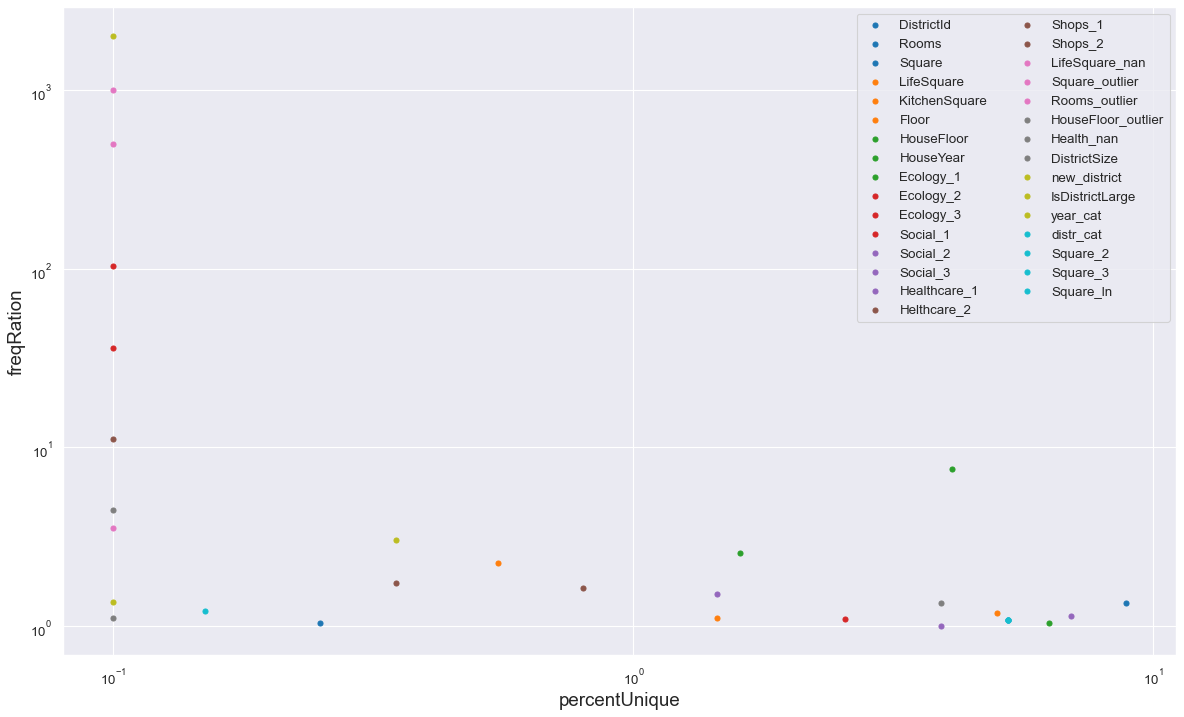

,features,freqRation,percentUnique
0,DistrictId,1.346457,8.85
1,Rooms,1.037838,0.25
2,Square,1.082192,5.25
3,LifeSquare,1.185185,5.00
4,KitchenSquare,2.258065,0.55
5,Floor,1.109890,1.45
6,HouseFloor,2.561753,1.60
7,HouseYear,7.626866,4.10
8,Ecology_1,1.045045,6.30
9,Ecology_2,104.263158,0.10


In [153]:
feature_info(X_valid)

Все признаки информативны.

In [154]:
X_valid.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'LifeSquare_nan', 'Square_outlier',
       'Rooms_outlier', 'HouseFloor_outlier', 'Health_nan', 'DistrictSize',
       'new_district', 'IsDistrictLarge', 'year_cat', 'distr_cat', 'Square_2',
       'Square_3', 'Square_ln'],
      dtype='object')

In [155]:
rf_model = RandomForestRegressor(random_state=28, criterion='mse', n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=28)

Train R2:	0.963
Test R2:	0.73


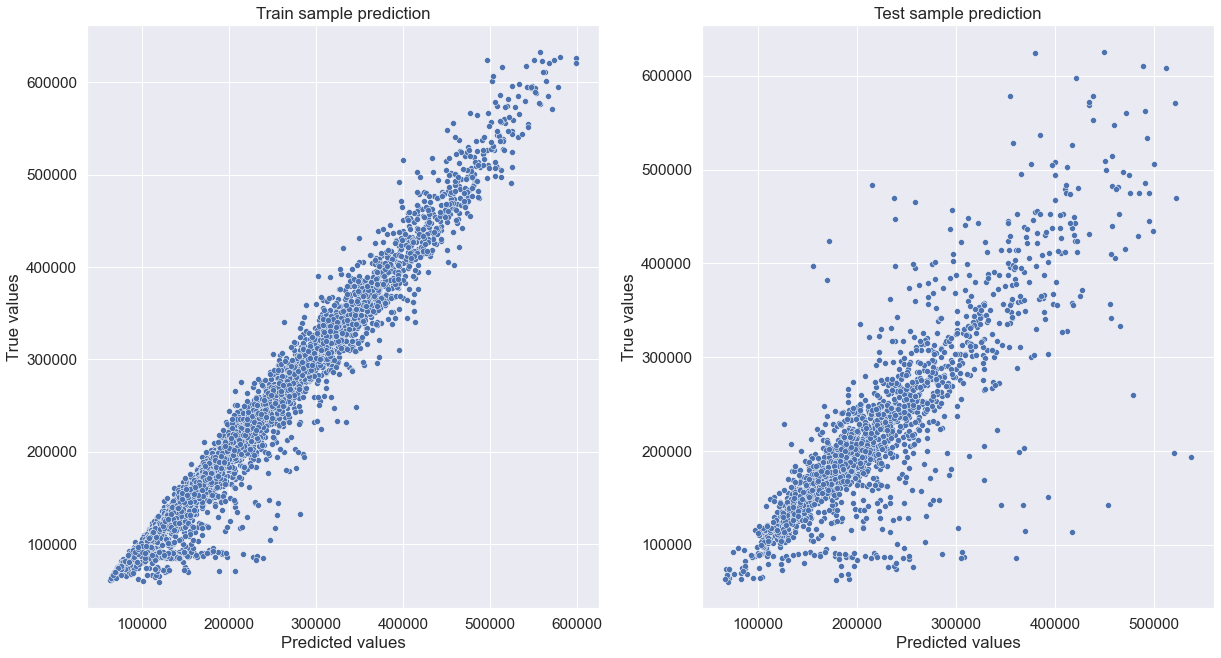

In [156]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [157]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73894834, 0.73910956, 0.72078445])

In [158]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=28))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.925
Test R2:	0.721


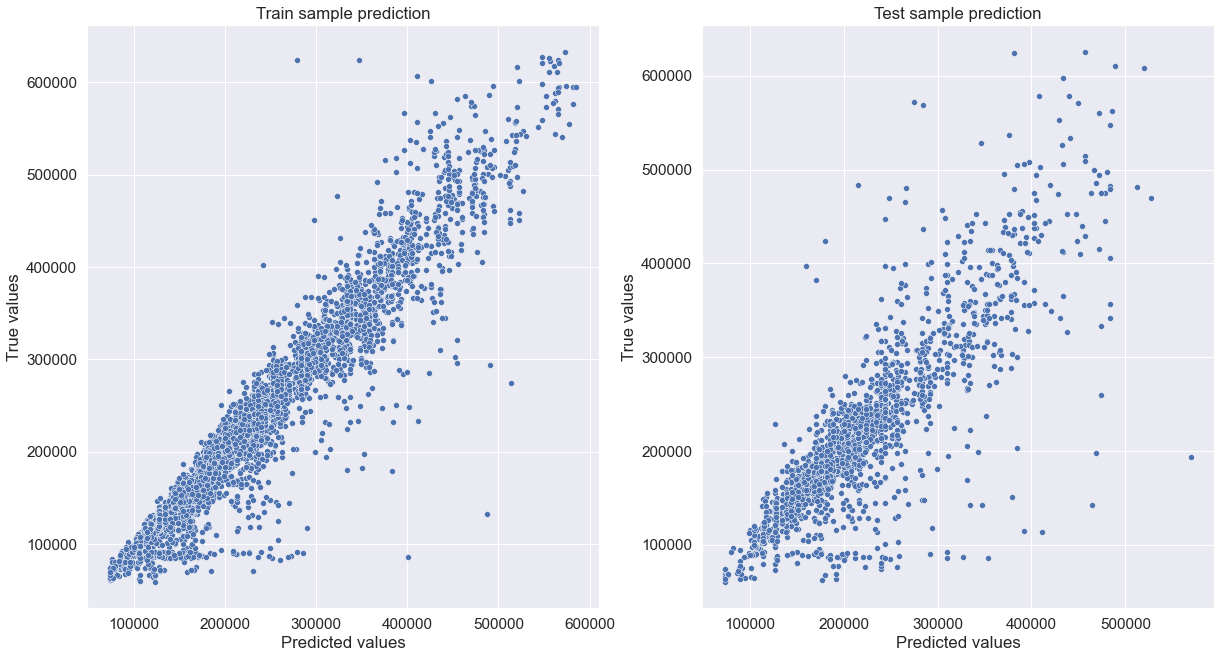

In [159]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Нарисуем график зависимоcти числа признаков от среднего значения коэффициента детерминации на крос-валидации

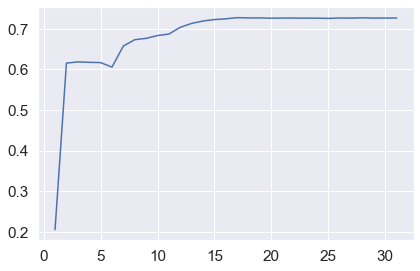

In [160]:
features = feat_imp_draw(X_train, y_train)

In [161]:
features

,feature_name,importance
27,distr_cat,0.235782
29,Square_3,0.126909
30,Square_ln,0.109342
2,Square,0.103487
28,Square_2,0.081738
13,Social_3,0.034471
7,HouseYear,0.027747
5,Floor,0.027119
1,Rooms,0.025543
3,LifeSquare,0.025314


По графику видно, что максимум в районе 17, поэтому признаки со значением важности ниже 0,017 отбросим.

In [162]:
columns = list(features.feature_name[features.importance > 0.017])
columns

['distr_cat',
 'Square_3',
 'Square_ln',
 'Square',
 'Square_2',
 'Social_3',
 'HouseYear',
 'Floor',
 'Rooms',
 'LifeSquare',
 'HouseFloor',
 'Healthcare_1',
 'DistrictSize',
 'Social_1',
 'Ecology_1',
 'DistrictId',
 'KitchenSquare',
 'Social_2']

Train R2:	0.963
Test R2:	0.736


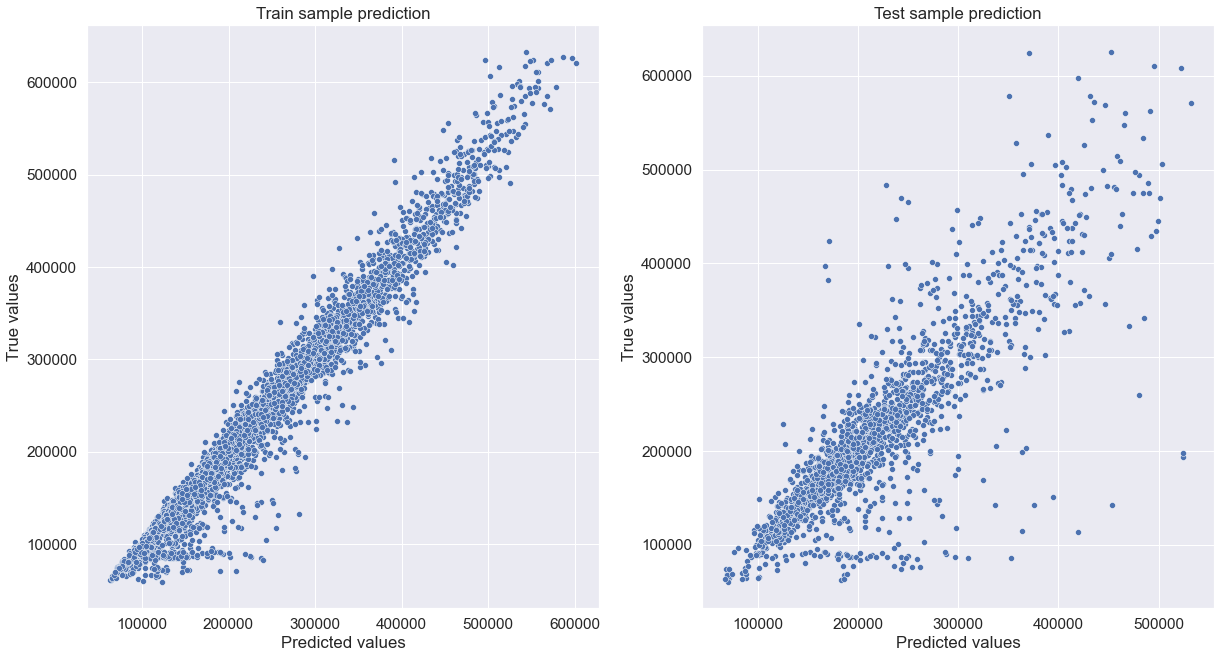

In [163]:
rf_model = RandomForestRegressor(random_state=28, criterion='mse', n_jobs=-1)
rf_model.fit(X_train[columns], y_train)

y_train_preds = rf_model.predict(X_train[columns])
y_test_preds = rf_model.predict(X_valid[columns])

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [164]:
cv_score = cross_val_score(rf_model, X_train[columns], y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
cv_score

array([0.73544733, 0.73156958, 0.71354738])

Видно, что на обучении результаты такие же, а на отложенной выборке даже чуть улучшились. Таким образом, оставляем эти 18 признаков

**Fine-tune**

In [165]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [166]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(mod, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(mod, X, y, 
                train_sizes=train_sizes, cv=cv, scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

def plot_validation_curve(mod, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(mod, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

In [167]:
# model = RandomForestRegressor(max_features=3, min_samples_split=8,
#                      n_estimators=300, random_state=28, n_jobs=-1)
# plot_validation_curve(model, X_train[columns], y_train, 'max_depth', [10,20,30,40,50], 'r2')

In [168]:
# model = RandomForestRegressor(max_depth=20, min_samples_split=8,
#                      n_estimators=300, random_state=28, n_jobs=-1)
# plot_validation_curve(model, X_train[columns], y_train, 'max_features', range(2, 6, 1), 'r2')

In [169]:
# model = RandomForestRegressor(max_depth=20, max_features=3, 
#                      n_estimators=300, random_state=28, n_jobs=-1)
# plot_validation_curve(model, X_train[columns], y_train, 'min_samples_split', range(2, 20, 2), 'r2')

In [170]:
# plot_validation_curve(model, X_train[columns], y_train, 'max_samples', np.linspace(0,1,10), 'r2')

In [171]:
model = RandomForestRegressor(max_depth=20, max_features=2, min_samples_split=2,
         max_samples=0.8, n_estimators=500, random_state=28, n_jobs=-1)

In [172]:
cv_score = cross_val_score(model, X_train[columns], y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
cv_score

array([0.73738263, 0.73608292, 0.72882747])

Train R2:	0.963
Test R2:	0.736


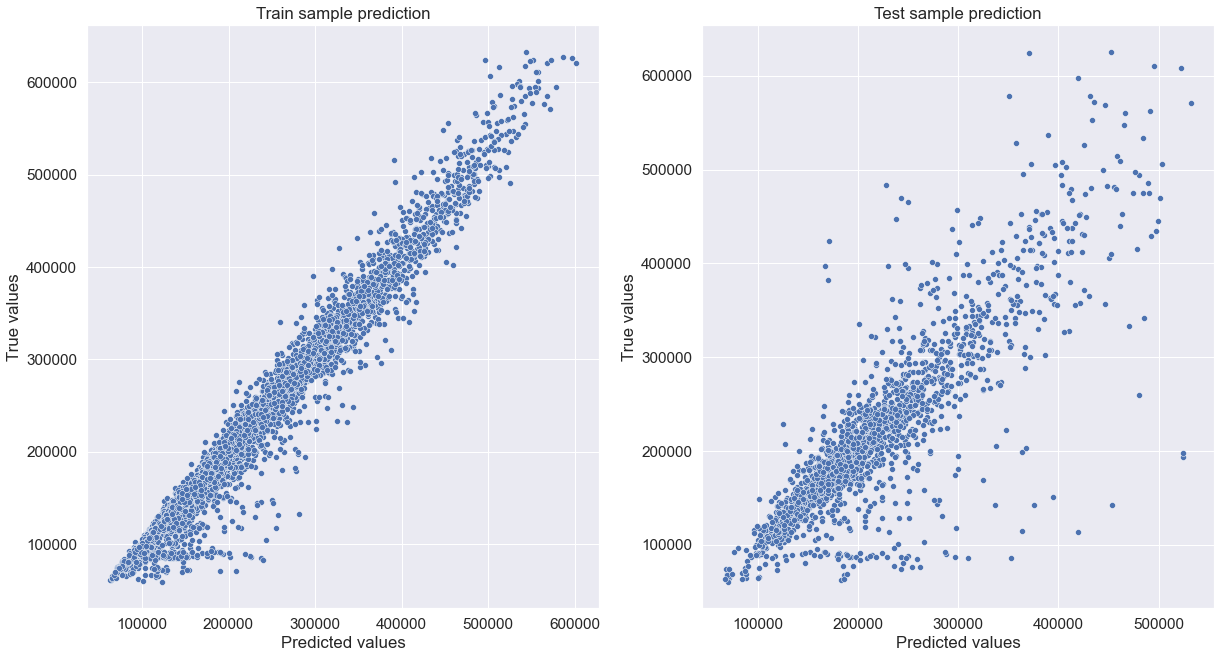

In [173]:
model.fit(X_train[columns], y_train)

y_train_preds = rf_model.predict(X_train[columns])
y_test_preds = rf_model.predict(X_valid[columns])

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

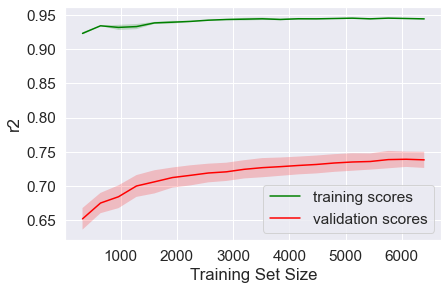

In [174]:
plot_learning_curve(model, X_train[columns], y_train, scoring='r2', cv=5)

Судя по кривой обучения данных не хватает.

**Прогнозирование на тестовом датасете**

In [175]:
submit = pd.read_csv(SUBM_PATH)
predictions = model.predict(test_df[columns])
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161050.306739
1,5925,115659.070716
2,960,140315.668554
3,3848,123791.995998
4,746,183032.979531


In [176]:
submit.to_csv('result_submit.csv', index=False, header = 1)

In [177]:
score_base_rf = 0.73428
print('Результат на kaggle (Public Score):', score_base_rf)

Результат на kaggle (Public Score): 0.73428
